# 手書き文字によるデモ

CNNを学習させて、実際に自分で書いた数字を推論させてみましょう。

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
# 実行結果が同じになるように乱数のシードを設定しておきます
tf.set_random_seed(1234)
np.random.seed(1234)

## モデルの構築

In [5]:
def weight_variable(shape):
    """初期化済みの重み"""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,trainable=True)

def bias_variable(shape):
    """初期化済みのバイアス"""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial,trainable=True)

In [6]:
def conv2d(X, W):
    """畳込み層"""
    return tf.nn.conv2d(X, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(X):
    """プーリング層"""
    return tf.nn.max_pool(X, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

* 入力層
* 教師データ（正解データ）

In [7]:
t = tf.placeholder(tf.float32, shape=(None,10))
x = tf.placeholder(tf.float32, shape=(None,784))
x_ = tf.reshape(x, [-1,28,28,1])

* 畳込み層→プーリング層→活性化関数(ReLU)

28x28 → 14x14

In [8]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

* 畳込み層→プーリング層→活性化関数(ReLU)

14x14 → 7x7

In [9]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

* 全結合層

In [10]:
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

* ドロップアウト

In [11]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

* 出力層

In [12]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

* ソフトマックス関数()

In [13]:
pred = tf.nn.softmax(y_conv)

* 誤差関数

In [14]:
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=t, logits=y_conv))

* 学習アルゴリズム

In [15]:
optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(loss)

* 精度(Accuracy)によるモデルの評価

In [16]:
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(t,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

=== モデルの構築 ここまで ===

## 学習の実行

In [17]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

500ステップごとに精度とコストを出力する

In [18]:
i = 0
# 学習ステップ数
n_steps = 1000
# 各自使用する環境のスペックに応じて変更してください 
# 10〜100くらい
batch_size = 20 
for _ in range(n_steps):
    i += 1
    batch = mnist.train.next_batch(20) 
    sess.run(train_step, feed_dict={x:batch[0],t:batch[1],keep_prob:0.5})
    if i % 500 == 0:
        train_acc, train_loss = sess.run([accuracy,loss], feed_dict={x: batch[0],t:batch[1],keep_prob:1.0})
        print("[Train] step: %d, loss: %f, acc: %f" % (i, train_loss, train_acc))

[Train] step: 500, loss: 0.295023, acc: 0.900000
[Train] step: 1000, loss: 0.099262, acc: 0.950000


## 学習後のテストデータによる評価

In [19]:
test_acc = sess.run(accuracy, feed_dict={x:mnist.test.images,t: mnist.test.labels,keep_prob:1.0})
print("[Test] accuracy: %f" % (test_acc))

[Test] accuracy: 0.950200


---

## デモ

enakai00さんのコードを参考に自分で手書き数字を作って、学習させたモデルに推論をさせてみます。

* [jupyter_tfbook/Chapter05/Handwriting recognizer.ipynb](https://github.com/enakai00/jupyter_tfbook/blob/master/Chapter05/Handwriting%20recognizer.ipynb)

In [20]:
input_form = """
<table>
<td style="border-style: none;">
<div style="border: solid 2px #666; width: 143px; height: 144px;">
<canvas width="140" height="140"></canvas>
</div></td>
<td style="border-style: none;">
<button onclick="clear_value()">Clear</button>
</td>
</table>
"""

In [21]:
javascript = """
<script type="text/Javascript">
    var pixels = [];
    for (var i = 0; i < 28*28; i++) pixels[i] = 0
    var click = 0;

    var canvas = document.querySelector("canvas");
    canvas.addEventListener("mousemove", function(e){
        if (e.buttons == 1) {
            click = 1;
            canvas.getContext("2d").fillStyle = "rgb(0,0,0)";
            canvas.getContext("2d").fillRect(e.offsetX, e.offsetY, 8, 8);
            x = Math.floor(e.offsetY * 0.2)
            y = Math.floor(e.offsetX * 0.2) + 1
            for (var dy = 0; dy < 2; dy++){
                for (var dx = 0; dx < 2; dx++){
                    if ((x + dx < 28) && (y + dy < 28)){
                        pixels[(y+dy)+(x+dx)*28] = 1
                    }
                }
            }
        } else {
            if (click == 1) set_value()
            click = 0;
        }
    });
    
    function set_value(){
        var result = ""
        for (var i = 0; i < 28*28; i++) result += pixels[i] + ","
        var kernel = IPython.notebook.kernel;
        kernel.execute("image = [" + result + "]");
    }
    
    function clear_value(){
        canvas.getContext("2d").fillStyle = "rgb(255,255,255)";
        canvas.getContext("2d").fillRect(0, 0, 140, 140);
        for (var i = 0; i < 28*28; i++) pixels[i] = 0
    }
</script>
"""

In [22]:
def predicate_and_plot(sess, pred, image):
    p_val = sess.run(pred, feed_dict={x:[image], keep_prob:1.0})
    fig = plt.figure(figsize=(4,2))
    pred_ = p_val[0]
    subplot = fig.add_subplot(1,1,1)
    subplot.set_xticks(range(10))
    subplot.set_xlim(-0.5,9.5)
    subplot.set_ylim(0,1)
    subplot.bar(range(10), pred_, align='center')
    for i, p in enumerate(pred_):
        print("数字 %i : %4.2f" % (i, p * 100.0))
    return subplot

再度自分で書いた数字を評価させる場合は、以下の2つのセルを再度実行してください。

=== 手書き数字用のセル ===

In [24]:
from IPython.display import HTML
HTML(input_form + javascript)

数字 0 : 0.01
数字 1 : 0.00
数字 2 : 0.58
数字 3 : 0.00
数字 4 : 99.09
数字 5 : 0.04
数字 6 : 0.15
数字 7 : 0.03
数字 8 : 0.02
数字 9 : 0.08


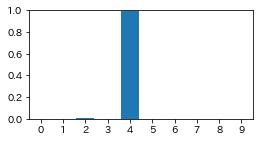

In [25]:
predicate_and_plot(sess, pred, image)

=== ここまでのセルを実行してください ===

---